# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is train LSTM model 

#### Import python library

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model 

import pickle
import joblib


In [4]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Define Variables

In [2]:
seed = 7
np.random.seed(seed)
modelname   = 'LSTM6b-3in2out'
batch_size  = 8192
no_of_epoch = 18
no_of_train = 0.8

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 2

### Define Function

In [70]:
def createModel(): 
    inputs  = Input(shape=(X_train.shape[1],X_train.shape[2]))
    y = LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
    y = BatchNormalization()(y)
    y = LSTM(128, return_sequences=True, dropout=0.3,recurrent_dropout=0.3)(y)
    y = BatchNormalization()(y)
    y = LSTM(units=256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)(inputs)
    y = BatchNormalization()(y)
    y = LSTM(128, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = LSTM(128, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
    return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#### Reading from Preprocessed & Test sample dataset

In [7]:
xls  = pd.ExcelFile('data/test_sample.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')
test_sample

,day,hour,min,dow,lat,long,demand
0,0.400000,0.608696,0.000000,0.666667,0.466667,0.200000,0.079452
1,0.350000,0.217391,0.666667,0.166667,0.711111,0.885714,0.077979
2,0.516667,0.043478,1.000000,0.666667,0.133333,0.285714,0.301448
3,0.016667,0.652174,0.666667,0.333333,0.200000,0.542857,0.012222
4,0.533333,0.043478,0.333333,0.833333,0.600000,0.228571,0.341291
5,0.666667,0.173913,0.666667,1.000000,0.600000,0.685714,0.363646
6,0.633333,0.391304,0.666667,0.666667,0.533333,0.885714,0.003396
7,0.616667,0.130435,0.333333,0.500000,0.577778,0.485714,0.175918
8,0.966667,0.043478,0.333333,0.500000,0.466667,0.342857,0.227344
9,0.650000,0.130435,0.333333,0.833333,0.822222,0.200000,0.032137


In [8]:
xls  = pd.ExcelFile('data/Dataset_feature.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

,day,hour,min,dow,lat,long,demand
0,0.283333,0.869565,0.000000,0.666667,0.533333,0.171429,0.020072
1,0.150000,0.608696,0.666667,0.500000,0.288889,0.200000,0.024721
2,0.133333,0.260870,0.333333,0.333333,0.644444,0.828571,0.102821
3,0.516667,0.217391,0.000000,0.666667,0.533333,0.428571,0.088755
4,0.233333,0.173913,0.000000,0.166667,0.288889,0.342857,0.074468
...,...,...,...,...,...,...,...
1048570,0.083333,0.347826,0.666667,1.000000,0.911111,0.771429,0.024022
1048571,0.366667,0.652174,0.666667,0.333333,0.111111,0.400000,0.005703
1048572,0.683333,0.652174,1.000000,0.000000,0.533333,0.200000,0.067131
1048573,0.016667,0.260870,0.666667,0.333333,0.711111,0.600000,0.151323


In [9]:
predictor_var = ['day', 'hour', 'min', 'dow', 'lat', 'long']
outcome_var   = 'demand'

#### Prepare training & test data
- Since this is a time series dataset, we can try using LSTM 

In [10]:
dataset = data.to_numpy()

In [11]:
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
print(X.shape, y.shape)

(1048572, 3, 6) (1048572, 2)


#### Train-test-val dataset split

In [12]:
X_train1 = X[:int(no_of_train*len(X))]
y_train1 = y[:int(no_of_train*len(X))]
X_test  = X[int(no_of_train*len(X)):]
y_test  = y[int(no_of_train*len(X)):]

X_train = X_train1[:int(no_of_train*len(X_train1))]
y_train = y_train1[:int(no_of_train*len(X_train1))]
X_val   = X_train1[int(no_of_train*len(X_train1)):]
y_val   = y_train1[int(no_of_train*len(X_train1)):]

In [13]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671085, 3, 6) (671085, 2) (209715, 3, 6) (209715, 2) (167772, 3, 6) (167772, 2)


<h2><center>Create Model and test</center><h2>

<h3>LSTM<h3>

In [71]:
model = createModel()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 3, 256)            269312    
_________________________________________________________________
batch_normalization_20 (Batc (None, 3, 256)            1024      
_________________________________________________________________
lstm_22 (LSTM)               (None, 3, 128)            197120    
_________________________________________________________________
batch_normalization_21 (Batc (None, 3, 128)            512       
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)               512 

In [72]:
model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])

In [73]:
# Create checkpoints to save model during training and save training data into csv
# ‘monitor’ can be ‘val_acc’ or ‘val_loss’
# When set to ‘val_acc’, ‘mode’ must be ‘max’; when set to ‘val_loss’, ‘mode’ must be ‘min’

filepath       = modelname + ".hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
csv_logger     = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint,csv_logger]

In [74]:
# The line for training
hisgtory = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_val, y_val), 
                     epochs=no_of_epoch, 
                     batch_size=batch_size,
                     shuffle=False,
                     callbacks=callbacks_list) 

Train on 671085 samples, validate on 167772 samples
Epoch 1/18
671085/671085 [==============================] - 12s 18us/sample - loss: 0.1240 - mse: 0.1240 - mae: 0.3092 - val_loss: 0.0371 - val_mse: 0.0371 - val_mae: 0.1646
Epoch 2/18
671085/671085 [==============================] - 6s 9us/sample - loss: 0.0295 - mse: 0.0295 - mae: 0.1225 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1001
Epoch 3/18
671085/671085 [==============================] - 6s 9us/sample - loss: 0.0257 - mse: 0.0257 - mae: 0.0987 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0947
Epoch 4/18
671085/671085 [==============================] - 6s 9us/sample - loss: 0.0255 - mse: 0.0255 - mae: 0.0971 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0975
Epoch 5/18
671085/671085 [==============================] - 6s 9us/sample - loss: 0.0254 - mse: 0.0254 - mae: 0.0970 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0984
Epoch 6/18
671085/671085 [==============================] - 6s 9us/sample - loss: 0.02

In [96]:
plot_model(model, 
             to_file=modelname + '.pdf', 
             show_shapes=True, 
             show_layer_names=False,
             rankdir='TB') 

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Test dataset test result

In [76]:
predicted_value = model.predict(X_test)
print(mean_squared_error(y_test,predicted_value))

0.025202787978996617


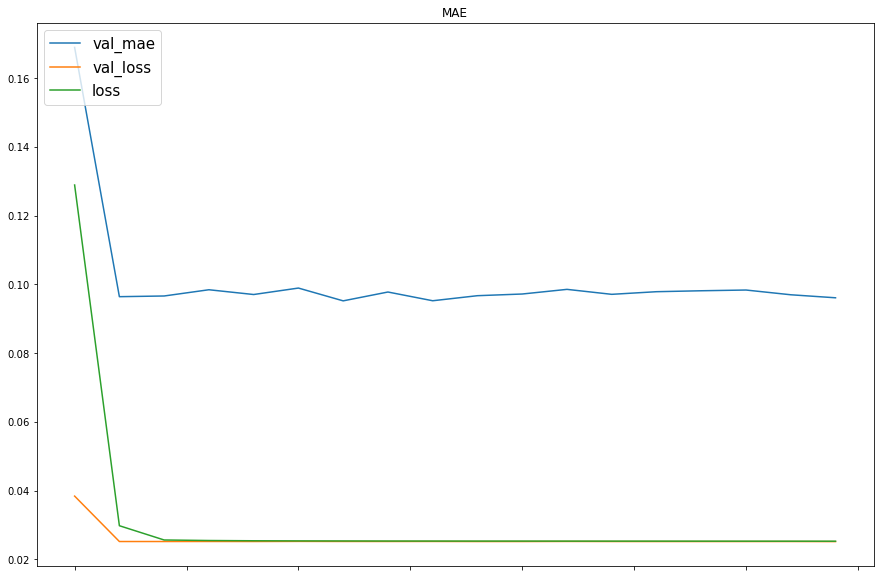

In [3]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()



### Load save LSTM model

In [78]:
# Load your own trained model
model = load_model(filepath, compile = False)

### Sample Testing 

In [79]:
scaler_filename = "grab_msft_scaler.save"
scaler          = joblib.load(scaler_filename) 

#### First set of testdata

In [80]:
# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [81]:
# covert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(18, 3, 6) (18, 2)


In [82]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.11145648 0.10619176]
 [0.1045894  0.10720474]
 [0.11688424 0.10800567]
 [0.11268303 0.10744818]
 [0.10326273 0.10615642]
 [0.1139407  0.10626089]
 [0.11605038 0.10687288]
 [0.10893407 0.10648803]
 [0.09795757 0.10636613]
 [0.10631792 0.10717518]
 [0.10876981 0.10489251]
 [0.08672648 0.10346142]
 [0.11747474 0.1067337 ]
 [0.11829785 0.10653808]
 [0.11196341 0.10613913]
 [0.10535137 0.10670798]
 [0.10059709 0.1065424 ]
 [0.09881267 0.1050429 ]] 
 Actual Value    : [[0.30144827 0.01222179]
 [0.01222179 0.3412908 ]
 [0.3412908  0.36364563]
 [0.36364563 0.00339634]
 [0.00339634 0.17591761]
 [0.17591761 0.22734446]
 [0.22734446 0.03213684]
 [0.03213684 0.0148439 ]
 [0.0148439  0.10047717]
 [0.10047717 0.21478451]
 [0.21478451 0.00904605]
 [0.00904605 0.03513281]
 [0.03513281 0.00620095]
 [0.00620095 0.03977563]
 [0.03977563 0.03086107]
 [0.03086107 0.02183922]
 [0.02183922 0.01137701]
 [0.01137701 0.17868729]]


In [83]:
print(mean_squared_error(y_sample,predicted_value))

0.013859367630914533


### single sample test

In [84]:
# Data input sequence format :
test_data1  = [[18,20, 0, 4, -5.353088, 90.653687],
               [10,14,30, 3, -5.413513, 90.664673],
               [ 9, 6,15, 2, -5.325623, 90.906372]]
test_data2  = [[32, 5, 0, 4, -5.353088, 90.752563],
               [15, 4, 0, 1, -5.413513, 90.719604],
               [ 1,12,15, 1, -5.336609, 90.609741]]
test_data3  = [[25, 3,30, 4, -5.391541, 90.818481],
               [51,20,45, 2, -5.408020, 90.631714],
               [48, 6,15, 6, -5.364075, 90.763550]]
test_data4  = [[ 4,22,15, 4, -5.402527, 90.675659],
               [45, 9,15, 3, -5.402527, 90.917358],
               [52,11,45, 3, -5.364075, 90.664673]]
test_data5  = [[46,12,15, 4, -5.353088, 90.642700],
               [34,14,45, 6, -5.375061, 90.807495],
               [40, 2,30, 5, -5.424500, 90.785522]]
test_data6  = [[14,14,45, 0, -5.391541, 90.598755],
               [27, 3,30, 6, -5.320129, 90.785522],
               [ 6,23,45, 6, -5.358582, 90.752563]]
test_data7  = [[48,11,30, 6, -5.391541, 90.609741],
                [17,23,45, 3, -5.292664, 90.829468],
                [56,10, 0, 0, -5.413513, 90.774536]]

test_target1 = [[0.102821],[0.088755]]
test_target2 = [[0.023843],[0.007460]]
test_target3 = [[0.054170],[0.123463]]
test_target4 = [[0.359406],[0.514136]]
test_target5 = [[0.026409],[0.013998]]
test_target6 = [[0.029400],[0.057255]]
test_target7 = [[0.008772],[0.119240]]

In [85]:
Data_scaled = scaler.transform(test_data1)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target1))

Predicted value : [[0.07490818 0.10593103]]
Actual Value    : [[0.102821], [0.088755]]


In [86]:
Data_scaled = scaler.transform(test_data2)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target2))

Predicted value : [[0.06045572 0.10090271]]
Actual Value    : [[0.023843], [0.00746]]


In [87]:
Data_scaled = scaler.transform(test_data3)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target3))

Predicted value : [[0.06354825 0.11097842]]
Actual Value    : [[0.05417], [0.123463]]


In [88]:
Data_scaled = scaler.transform(test_data4)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target4))

Predicted value : [[0.07701512 0.11632581]]
Actual Value    : [[0.359406], [0.514136]]


In [89]:
Data_scaled = scaler.transform(test_data5)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target5))

Predicted value : [[0.08277538 0.11711656]]
Actual Value    : [[0.026409], [0.013998]]


In [90]:
Data_scaled = scaler.transform(test_data6)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target6))

Predicted value : [[0.0754217  0.10386465]]
Actual Value    : [[0.0294], [0.057255]]


In [91]:
Data_scaled = scaler.transform(test_data7)
Data_scaled = Data_scaled.reshape(1,n_steps_in,6)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target7))

Predicted value : [[0.06261808 0.11086673]]
Actual Value    : [[0.008772], [0.11924]]
